In [1]:
%matplotlib inline
import gym  # open ai gym
#mport pybulletgym # register PyBullet enviroments with open ai gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import torch

from pyvirtualdisplay import Display
Display(visible=0, size=(960, 720)).start()  

In [2]:
env = gym.make('CartPole-v0')
## State
# Cart position [-4.8, 4.8]
# Velocity [-Inf, Inf]
# Pole Angle [-0.418 rad (-24 deg), 0.418 rad (24 deg)]
# Pole Angular Velocity [-Inf, Inf]

## Action
# 0 left
# 1 right

In [3]:
env.env.tau = 0.005

In [4]:
import torch
import norse.torch as nn

In [5]:
state = None

In [6]:
def ask_network(observation, state=None, activities = []):
    observation = torch.tensor(observation)
    action, state = model(observation, state)
    return 0 if action > 0 else 1, state

In [7]:
linear = torch.nn.Linear(4, 1, bias=False)
model = nn.SequentialState(
    nn.LIFCell(),
    linear,
    nn.LIFCell()
).eval()

In [8]:
activities = []
def forward_state_hook(mod, inp, out):
    activities.append(out[0].detach())
model.register_forward_state_hooks(forward_state_hook)

In [9]:
def draw_layer(ys, x, axes):
    xs_0 = [x for y in ys if not y == 1]
    if len(ys) == 1:
        lin = [0.5]
    else:
        lin = torch.linspace(0, 1, len(ys))
    ys_0 = [c for (c, y) in zip(lin, ys) if not y == 1]
    points = axes.plot(xs_0, ys_0, 'ob', markersize=50)
    xs_1 = [x for y in ys if y == 1]
    ys_1 = [c for (c, y) in zip(lin, ys) if y == 1]
    points = axes.plot(xs_1, ys_1, 'or', markersize=60)

In [10]:
def draw_model(activities):
    plt.gca().set_xlim(-0.5, 1.5)
    plt.gca().set_ylim(-0.2, 1.2)
    for i, layer in enumerate(activities):
        draw_layer(layer, i, plt)

In [11]:
linear.weight = torch.nn.Parameter(
    torch.Tensor([[1, 1, 1, 1]])
)

In [12]:
linear.weight = torch.nn.Parameter(torch.Tensor([[2, 1, 0., 0.]]))

In [13]:
ask_network(env.reset(), state)
activities

[tensor([0., 0., 0., 0.]), tensor([0.])]

TypeError: iteration over a 0-d tensor

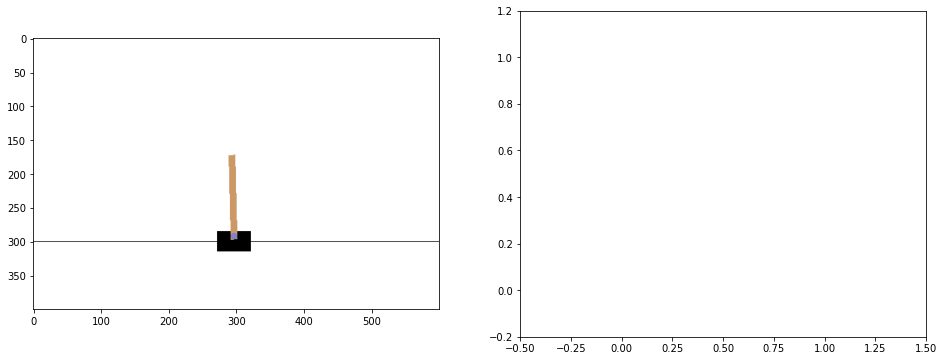

In [14]:

observation = env.reset()
state = None
is_done = False
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
img = ax1.imshow(env.render(mode='rgb_array')) # only call this once
vs = [0] * 50
while not is_done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    
    display.display(f)
    display.clear_output(wait=True)
    action, state = ask_network(observation, state)
    vs.append(state[-1].v.detach())
    ax2.clear()
    ax2.set_ylim(-2, 2)
    #ax2.plot(vs)
    draw_model([x[0].detach() for x in activities])
    if len(vs) > 49:
        vs = vs[1:]
    observation, _, is_done, _ = env.step(action)